In [12]:
from pathlib import Path
import pygimli as pg  # Stelle sicher, dass das Modul pg importiert ist und verfügbar ist
from pygimli.physics import ert
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import numpy as np

from Hilfsfunktionen import T_corr_nach_Inversion
from Hilfsfunktionen import plotting_function
from Hilfsfunktionen import plotting_function_FTL

# Read data
file = "two_timesteps.ohm"
base_dir = Path("filtered_data")
data_two = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "two_timesteps.ohm" 
        if datei_pfad.exists():
            daten_objekt = pg.load(str(datei_pfad))
            data_two.append([unterordner.name, daten_objekt])
            print(f"Load data: {datei_pfad}")

# Read data
file = "all_timesteps_high_error.ohm"
base_dir = Path("filtered_data")
data_all_high_error = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "all_timesteps_high_error.ohm" 
        if datei_pfad.exists():
            if str(datei_pfad).startswith('filtered_data\\240610') or str(datei_pfad).startswith('filtered_data\\240704'):
                daten_objekt = pg.load(str(datei_pfad))
                data_all_high_error.append([unterordner.name, daten_objekt])
                print(f"Load data: {datei_pfad}")

# Read data
file = "all_timesteps.ohm"
base_dir = Path("filtered_data")
data_all = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "all_timesteps.ohm" 
        if datei_pfad.exists():
            if str(datei_pfad).startswith('filtered_data\\240610') or str(datei_pfad).startswith('filtered_data\\240704'):
                daten_objekt = pg.load(str(datei_pfad))
                data_all.append([unterordner.name, daten_objekt])
                print(f"Load data: {datei_pfad}")

chi2_oT = []
chi2_wT = []
rrms_oT = []
rrms_wT = []
mod_oT = []
mod_wT = []

for data in [data_two,data_all,data_all_high_error]:
    # Create method manager
    manager = []
    for ts in data:
        manager.append(ert.ERTManager(ts[1], verbose=True))
    
    # Create mesh
    mesh = manager[0].createMesh(quality = 34, paraMaxCellSize=0.5, paraDepth=15)
    manager[0].invert(quality = 34, paraMaxCellSize=0.5, maxIter=1 ,dPhi= 0.1, paraDepth=15,lam=20)
    
    # Inversion without temperature correction
    DATA = [dat[1] for dat in data]
    # Full time-lapse
    scalef = 0.7
    fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
    fop.setData(DATA)
    #manager[0].createMesh(quality=34,paraMaxCellSize=20)
    fop.setMesh(mesh)
    print(fop.mesh())  # important to call mesh() function once!
    dataVec = np.concatenate([data["rhoa"] for data in DATA])
    errorVec = np.concatenate([data["err"] for data in DATA])
    startModel = fop.createStartModel(dataVec)
    inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
    model = inv.run(dataVec, errorVec, maxIter=10, lam= 20, startModel=startModel, verbose=True)
    chi2_oT.append(round(inv.chi2(),2))
    rrms_oT.append(round(inv.relrms(),2))
    mod = np.reshape(model, [len(DATA), -1])
    mod_oT.append(mod)
    
    # Temperature correction    
    mod_corr = [] 
    temp_spread = []
    timestep = 0
    ort = 'Langer-Kamp'
    mesh2 = manager[0].mesh.createSubMesh(manager[0].mesh.cells(manager[0].mesh.cellMarkers() == 2))
    for count, m in enumerate(mod):
        timestep = count + 11
        dateien = os.listdir(".\Temperature_data/" + ort )
        
        for datei in dateien: 
            if (datei).startswith('T_Profil%s_array' % (str(timestep))):
                Temp_tiefe_vektor = np.load(".\Temperature_data/" + ort + '/' + datei, allow_pickle=True)
        res_new,Tem_new = T_corr_nach_Inversion(m, mesh2, Temp_tiefe_vektor)
        mod_corr.append(res_new) # Reference inversion
    
    modell2 = np.reshape(mod, -1)
    modell_corr = np.reshape(mod_corr, -1)
    response = inv.fop.response(modell2)
    response_t_corr = inv.fop.response(modell_corr)
    difference = response_t_corr - response
    diff = np.reshape(difference, [len(DATA), -1])
    for h in range(len(diff)):
        DATA[h]['rhoa'] = DATA[h]['rhoa'] + diff[h]
        
        
    # Inversion with temperature correction
    # Full time-lapse
    scalef = 0.7
    fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
    fop.setData(DATA)
    fop.setMesh(mesh)
    print(fop.mesh())  # important to call mesh() function once!
    dataVec = np.concatenate([data["rhoa"] for data in DATA])
    errorVec = np.concatenate([data["err"] for data in DATA])
    startModel = fop.createStartModel(dataVec)
    inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
    model = inv.run(dataVec, errorVec, maxIter=10, lam= 20, startModel=startModel, verbose=True)
    chi2_wT.append(round(inv.chi2(),2))
    rrms_wT.append(round(inv.relrms(),2))
    mod_Tcorr = np.reshape(model, [len(DATA), -1])
    mod_wT.append(mod_Tcorr)


Load data: filtered_data\240610\two_timesteps.ohm
Load data: filtered_data\240704\two_timesteps.ohm
Load data: filtered_data\240610\all_timesteps_high_error.ohm
Load data: filtered_data\240704\all_timesteps_high_error.ohm
Load data: filtered_data\240610\all_timesteps.ohm
Load data: filtered_data\240704\all_timesteps.ohm


24/04/25 - 18:25:55 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:25:55 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 18:25:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:25:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:25:55 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:25:55 - pyGIMLi - INFO - Use median(data values)=107.75
24/04/25 - 18:25:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=107.750000/107.750000
24/04/25 - 18:25:55 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000029EF0A32200>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029EF0A30EA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A30A90>
min/max (data): 23.04/1126
min/max (error): 10%/10.04%
min/max (start model): 108/108
--------------------------------------------------------------------------------


24/04/25 - 18:26:26 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:26:26 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:26:26 - pyGIMLi - INFO - Creating forward mesh from region infos.


inv.iter 0 ... chi² =   79.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   15.01 (dPhi = 76.24%) lam: 20.0


24/04/25 - 18:26:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:26:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:26:27 - pyGIMLi - INFO - Starting inversion.


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029EEF912020>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF0946EA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A337E0>
min/max (data): 21.96/1126
min/max (error): 10%/10.05%
min/max (start model): 108/108
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   92.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    9.84 (dPhi = 87.25%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.38 (dPhi = 22.31%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.54 (dPhi = 2.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.i

24/04/25 - 18:29:33 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:29:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:29:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:29:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:29:34 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:29:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029E7A646B60>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF0946F10>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EEF913E70>
min/max (data): 11.09/1114
min/max (error): 10%/10.05%
min/max (start model): 85.01/85.01
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  143.43
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   13.68 (dPhi = 89.05%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.84 (dPhi = 24.76%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    7.79 (dPhi = 2.91%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.41 (dPhi = 0.61%) lam: 20.0
############

24/04/25 - 18:32:06 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:32:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 18:32:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:32:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:32:06 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:32:06 - pyGIMLi - INFO - Use median(data values)=130.92
24/04/25 - 18:32:06 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=130.920000/130.920000
24/04/25 - 18:32:06 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000029EF0A300E0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029EF0A33AB0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A30220>
min/max (data): 37.19/1043
min/max (error): 5%/5.03%
min/max (start model): 131/131
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  342.55
--------------------------------------------------------------------------------
inv.iter 1 ... 

24/04/25 - 18:32:35 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:32:35 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:32:35 - pyGIMLi - INFO - Creating forward mesh from region infos.


chi² =   29.76 (dPhi = 88.12%) lam: 20.0


24/04/25 - 18:32:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:32:36 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:32:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029EF0A33D80>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF0947220>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A320C0>
min/max (data): 32.29/1043
min/max (error): 5%/5.03%
min/max (start model): 132/132
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  307.58
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   27.33 (dPhi = 87.72%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.55 (dPhi = 56.44%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.07 (dPhi = 4.35%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.94 (dPhi = 0.21%) lam: 20.0
##################

24/04/25 - 18:35:12 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:35:12 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:35:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:35:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:35:12 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:35:13 - pyGIMLi - INFO - Starting inversion.


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029E7D483330>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF09470D0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A332E0>
min/max (data): 20.13/919
min/max (error): 5%/5.03%
min/max (start model): 104/104
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  386.53
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   34.45 (dPhi = 88.28%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.23 (dPhi = 56.04%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    7.15 (dPhi = 5.14%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter

24/04/25 - 18:37:19 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:37:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 18:37:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:37:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:37:19 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:37:19 - pyGIMLi - INFO - Use median(data values)=98.94
24/04/25 - 18:37:19 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=98.940000/98.940000
24/04/25 - 18:37:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000029EEEE22660>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029EF0A321B0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A300E0>
min/max (data): 2.42/2525
min/max (error): 5%/1.0e+06%
min/max (start model): 98.94/98.94
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  240.89
--------------------------------------------------------------------------------
inv.iter 1 ... 

24/04/25 - 18:37:54 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:37:54 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:37:55 - pyGIMLi - INFO - Creating forward mesh from region infos.


chi² =   38.16 (dPhi = 81.43%) lam: 20.0


24/04/25 - 18:37:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:37:55 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:37:56 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029EF0A335B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF09473E0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EF0A33650>
min/max (data): 2.42/2703
min/max (error): 5%/1.0e+06%
min/max (start model): 99.47/99.47
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  212.71
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   23.96 (dPhi = 86.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.11 (dPhi = 58.10%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.82 (dPhi = 5.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.78 (dPhi = 0.13%) lam: 20.0
############

24/04/25 - 18:42:37 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:42:37 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:42:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:42:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:42:38 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:42:39 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000029EEF343240>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029EF0946F10>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029EEF15F880>
min/max (data): -27.1/2693
min/max (error): 5%/1.0e+06%
min/max (start model): 79.39/79.39
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  327.96
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   33.34 (dPhi = 88.15%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.13 (dPhi = 57.83%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.05 (dPhi = 7.52%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    9.01 (dPhi = 0.27%) lam: 20.0
###########

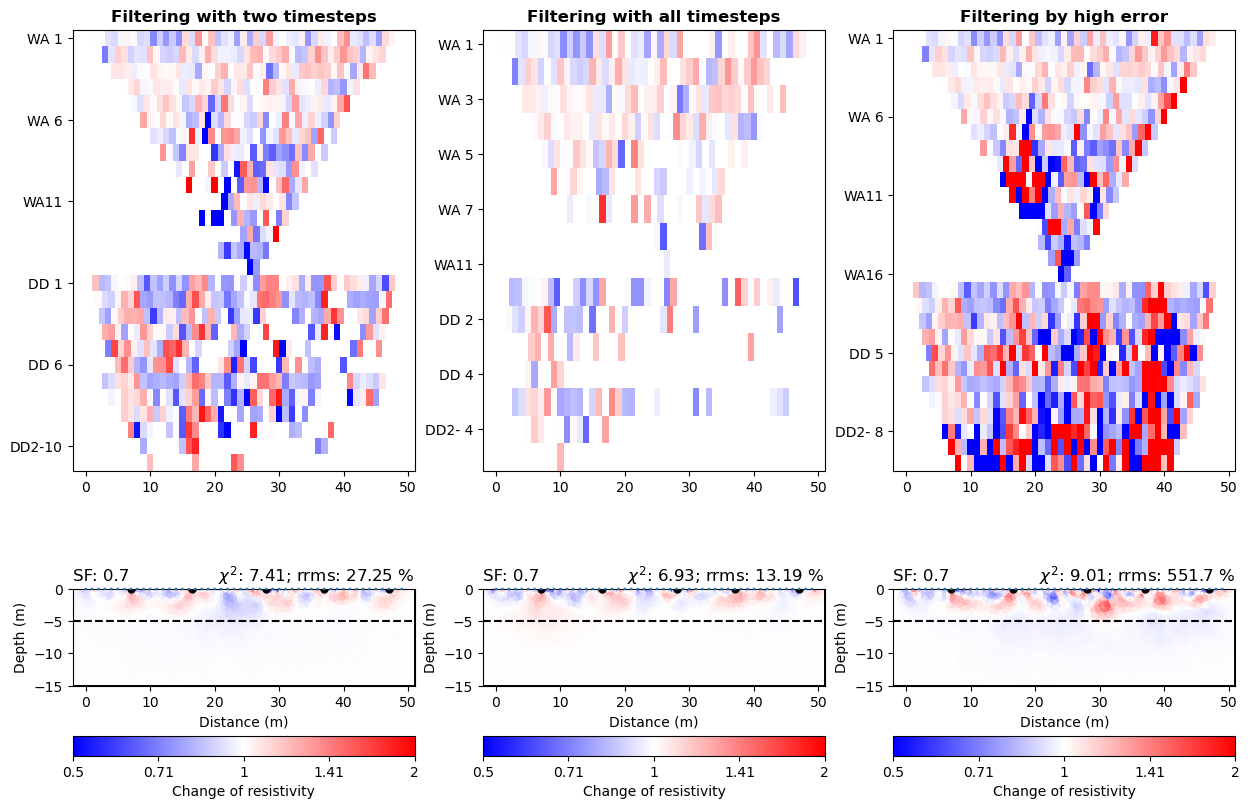

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, height_ratios=[4, 2],figsize=(15, 10))
title_list = ['Filtering with two timesteps', 'Filtering with all timesteps', 'Filtering by high error']
for (nr, result), data, chi, rrms, title in zip(enumerate(mod_wT), [data_two,data_all,data_all_high_error], chi2_wT, rrms_wT, title_list):
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[4, 2])  # Höhe des zweiten Subplots verdoppelt
    
    #datum = datetime.strptime(data[0], '%y%m%d')
    bild1 = ert.show(data[1][1], (data[1][1]['rhoa'])/data[0][1]['rhoa'], ax= axs[0,nr], cMin=0.5, cMax=2, cMap= 'bwr', logScale= True,label = 'Change of app. resistivity');
    axs[0,nr].set_title(title, fontweight='bold')
    axs[0,nr].set_xlim(-2, 51) 
    cb1 = bild1[-1]
    cb1.remove() 
    
    ratio =result[1] / result[0]
    bild2 = manager[0].showResult(model= ratio,coverage = manager[0].coverage(),
            cMin=1/2, cMax=2, cMap= 'bwr', ax= axs[1, nr], label = 'Change of resistivity', logScale= True) 
    axs[1, nr].set_title('$\chi^2$: '+ str(chi) + '; rrms: '+ str(rrms)+ ' %',  loc = 'right')
    axs[1, nr].set_title('SF: '+ str(0.7), loc = 'left')
    # Langer Kamp
    tree_postions = [7, 16.5, 28, 37, 47]
    for x in tree_postions:
        axs[1, nr].plot(x, 0, '.', markersize=10, color='black')
    axs[1, nr].axhline(y=-5, color='k', linestyle='--')
    #axs[axnr, 0].axhline(y=-5, color='k', linestyle='--')
    axs[1, nr].set_ylim(-15, 0) 
    
    plt.subplots_adjust(hspace=0.01) 
    
    axs[1, nr].set_xlabel('Distance (m)')
    axs[1, nr].set_ylabel('Depth (m)')
fig.savefig('./Fig12/' + '/comparison_filtering.png' , bbox_inches = 'tight', dpi=300)